# Monocular Depth Estimation - Pix2Pix
We explore the application of Pix2Pix, a conditional Generative Adversarial Network (GAN), for the task of monocular depth estimation.
Monocular depth estimation involves predicting depth information from a single RGB image, and Pix2Pix can be employed as a deep learning approach to tackle this challenging computer vision problem.

## Setting up the environment

In [1]:
import tensorflow as tf
import numpy as np

import os
import cv2
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display
from PIL import Image

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Preparing the Dataset

In [2]:
DATASET_DIRECTORY = '/kaggle/input/monocular-depth-estimation/val/indoors'

dataset = {}
for subdir, dirs, files in os.walk(DATASET_DIRECTORY):
  for file in files:
    basename = os.path.basename(os.path.join(subdir, file))
    if basename[-3:] == "png":
      basename = basename[:-4]
      kind = "rgb"
    elif basename[-9:] == "depth.npy":
      basename = basename[:-10]
      kind = "depth"
    elif basename[-14:] == "depth_mask.npy":
      basename = basename[:-15]
      kind = "mask"
    else:
      continue

    if not basename in dataset:
      dataset[basename] = { "rgb": None, "depth": None, "mask": None }
    dataset[basename][kind] = os.path.join(subdir, file)

In [3]:
def load(name: str):
  name = name
  rgb = dataset[name]["rgb"]
  rgb = tf.io.read_file(rgb)
  rgb = tf.io.decode_png(rgb)
  rgb = tf.image.convert_image_dtype(rgb, np.float32)

  depth = dataset[name]["depth"]
  depth = np.load(depth).squeeze()

  mask = dataset[name]["mask"]
  mask = np.load(mask)
  mask = mask > 0

  max_depth = min(300, np.percentile(depth, 99))
  depth = np.clip(depth, 0.1, max_depth)
  depth = np.log(depth, where=mask)
  depth = np.ma.masked_where(~mask, depth)
  depth = np.clip(depth, 0.1, np.log(max_depth))
  depth = np.expand_dims(depth, axis=2)
  depth = np.concatenate([depth] * 3, axis=2)
  depth = ((depth - np.min(depth)) / (np.max(depth) - np.min(depth)))
  depth = tf.cast(depth, tf.float32)

  return rgb, depth

In [4]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [5]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [6]:
def normalize(input_image, real_image):
  input_image = (input_image * 2) - 1
  real_image = (real_image * 2) - 1

  return input_image, real_image

In [7]:
def denormalize(image):
  input_image = (image + 1) / 2

  return image

In [8]:
@tf.function()
def random_jitter(input_image, real_image):
  input_image, real_image = resize(input_image, real_image, 286, 286)

  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

In [9]:
def load_image_train(image_file):
  image_file = bytes.decode(image_file.numpy())

  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [10]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image, IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

## Hyperparameters

In [11]:
BUFFER_SIZE     = 325
BATCH_SIZE      = 1
IMG_WIDTH       = 256
IMG_HEIGHT      = 256
OUTPUT_CHANNELS = 3
NUM_STEPS       = 10000

In [12]:
rgb, depth = load('00019_00183_indoors_000_010')
rgb, depth = resize(rgb, depth, IMG_HEIGHT, IMG_WIDTH)
rgb, depth = normalize(rgb, depth)

In [13]:
files = list(dataset.keys())
train_dataset = tf.data.Dataset.from_tensor_slices(files)
train_dataset = train_dataset.map(lambda x: tf.py_function(load_image_train, [x], [tf.float32, tf.float32]),
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [14]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [15]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [16]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [17]:
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [18]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [19]:
generator = Generator()
discriminator = Discriminator()

In [20]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
  total_disc_loss = real_loss + generated_loss
  return total_disc_loss

In [21]:
generator_optimizer = tf.keras.optimizers.experimental.RMSprop(2e-4)
discriminator_optimizer = tf.keras.optimizers.experimental.RMSprop(2e-4)

In [22]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [23]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  for i in range(3):
    display_list[i] = display_list[i] * 0.5 + 0.5
  title = ['RGB Image', 'Depth Image', 'Predicted Image']

    
  plt.subplot(1, 3, 1)
  plt.title('RGB Image')
  plt.imshow(display_list[0])
  plt.axis('off')
             
  plt.subplot(1, 3, 2)
  plt.title('Depth (Real) Image')
  plt.imshow(display_list[1][:,:,0], cmap='plasma')
  plt.axis('off')
             
  plt.subplot(1, 3, 3)
  plt.title('Depth (Estimated) Image')
  plt.imshow(display_list[2][:,:,0], cmap='plasma')
  plt.axis('off')

  plt.show()

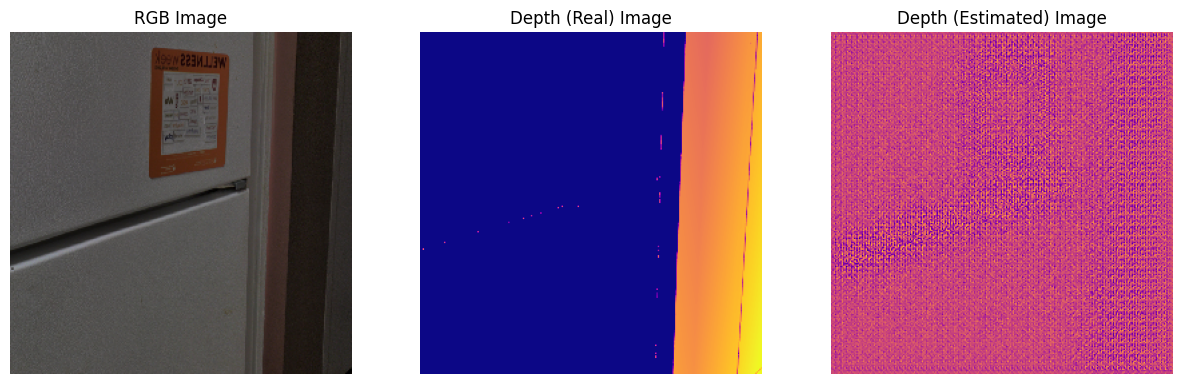

In [24]:
for example_input, example_target in train_dataset.take(1):
  generate_images(generator, example_input, example_target)

In [25]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [26]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

In [27]:
def fit(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('#', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

Time taken for 1000 steps: 60.19 sec



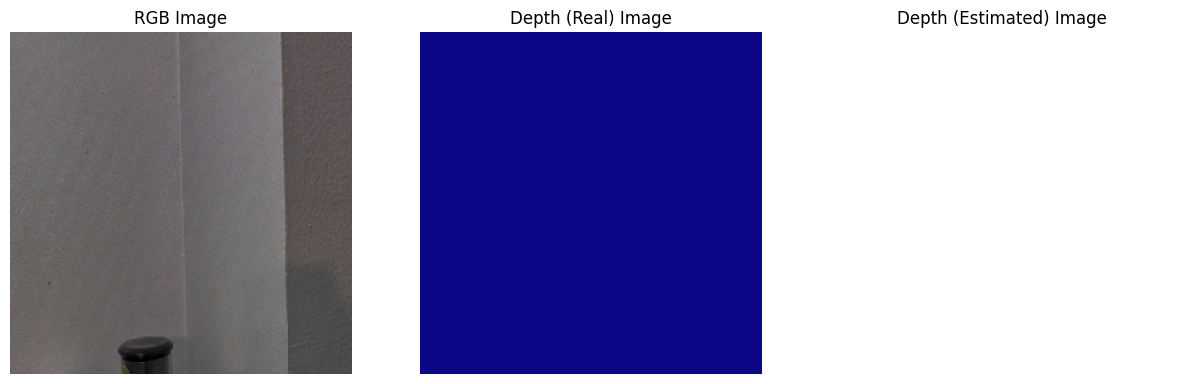

Step: 9k
####################################################################################################

In [28]:
fit(train_dataset, train_dataset, steps=NUM_STEPS)

In [29]:
import cv2
def psnr(model, test_input, tar):
  prediction = model(test_input, training=True)

  d = [test_input[0], tar[0], prediction[0]]
  for i in range(3):
    d[i] = d[i] * 0.5 + 0.5
    d[i] = d[i].numpy()
  return cv2.PSNR(d[1], d[2])

def calc():
    psnrs = []
    for example_input, example_target in train_dataset.take(64):
      val = psnr(generator, example_input, example_target)
      psnrs.append(val)
    return np.mean(psnrs)

In [30]:
print("Mean PNSR:", calc())

Mean PNSR: nan
